In [31]:
"""
This module processes renewable energy data, stores it in a SQLite database, and generates visualizations.
"""
import math
import numpy as np
import pandas as pd
import sqlalchemy
from matplotlib import pyplot as plt
from sqlalchemy import create_engine
from sqlalchemy import Column, Integer, String, Float
from sqlalchemy.orm import sessionmaker, scoped_session
from sqlalchemy.ext.declarative import declarative_base
from Big_O import time_complexity # Custom decorator for time complexity analysis
"""
Dependencies: math, numpy, pandas, sqlalchemy, matplotlib
"""

'\nDependencies: math, numpy, pandas, sqlalchemy, matplotlib\n'

In [32]:
engine = create_engine('sqlite:///FC724_PA2.db')	# Initialize SQLite database engine and session
Base = sqlalchemy.orm.declarative_base()
Session = sessionmaker(bind=engine)

In [33]:
class SQLTable(Base):				# Represents the 'REA' table in the SQLite database.
	__tablename__ = 'REA'

	id = Column(Integer, primary_key=True)
	Country = Column(String)
	Year = Column(Integer)
	Total_Energy_Consumption = Column(Float, name='Total Energy Consumption (TWh)')
	Renewable_Energy = Column(Float, name='Renewable Energy (%)')
	Government_Investment = Column(Float, name='Government Investment (Million USD)')
	Emissions_Reduction = Column(Float, name='Emissions Reduction (%)')
	Solar = Column(Float)
	Wind = Column(Float)
	Hydro = Column(Float)
	Geothermal = Column(Float)
	Biomass = Column(Float)
	Other_Renewables = Column(Float, name='Other Renewables')

Base.metadata.create_all(engine)	# Create the table in the database

In [34]:
class Transaction:		#Context manager for database transactions to ensure commit/rollback on errors.
	def __init__(self):
		self.session = Session()

	def __enter__(self):
		return self.session

	def __exit__(self, exc_type, exc_val, exc_tb):
		if exc_type is None:
			try:
				self.session.commit()
			except:
				self.session.rollback()
				raise
		else:
			self.session.rollback()
			raise
		self.session.close()

with Transaction() as transaction:	#Initialize transaction
	transaction.query(SQLTable)		#placeholder query to verify table existence

In [35]:
@time_complexity
def process_item(column: list[str | int | np.float64]) -> list[str | int | float] | None:
	"""
	params: column: list[str|np.float_]
	return: list[str|np.float_] | None
	None for drop
	"""
	assert column[0], "Country name cannot be empty"
	assert column[1], "Year cannot be empty"
	assert column[2], "Total Energy Consumption (TWh) cannot be empty"

	column[1] = int(column[1])		# Convert year to integer

	if not math.isnan(column[3]) and all([not math.isnan(item) for item in column[6:]]):	# Case 1: All renewable components are valid
		return column

	if math.isnan(column[3]):		# Case 2: Renewable Energy (%) is missing but components are valid
		if all([not math.isnan(item) for item in column[6:]]):
			column[3] = sum(column[6:])		# Calculate total from components
			return column
		else:
			# There are over two NaN values in the dataset could fix.
			return None		# Drop irreparable rows

	nan_index = None		# Case 3: One renewable component is missing; calculate it from total
	accumulated_value = 0
	for i, item in enumerate(column[6:], start=6):
		if math.isnan(item):
			if nan_index is not None:
				break		# Multiple missing components; drop row
			nan_index = i
		else:
			accumulated_value += item
	else:
		column[nan_index] = column[3] - accumulated_value		# Fill missing value
		return column

	return None		# Drop rows with multiple missing components

In [36]:
@time_complexity
def process_data(df_csv: pd.DataFrame) -> list[list[str | int | float]]:
	"""
	params: df_csv: pd.DataFrame
	return: list[list[str|int|np.float_]]
	"""
	processed_data = []			# Step 1: Clean data row-by-row
	for i in range(len(df_csv["Country"])):
		temp = []
		for row_name in df_csv:
			temp.append(df_csv[row_name][i])
		processed_item = process_item(temp)
		if processed_item is not None:
			processed_data.append(processed_item)

	interpolated_data = []		# Step 2: Interpolate missing 'Government_Investment'
	for i, item in enumerate(processed_data):
		if not math.isnan(item[4]):
			interpolated_data.append(item)
			continue
		left_ptr = i - 1		# Find nearest valid values for interpolation
		right_ptr = i + 1
		while left_ptr >= 0:
			if not math.isnan(processed_data[left_ptr][4]):
				break
			left_ptr -= 1
		else:
			left_ptr = None

		while right_ptr < len(processed_data):
			if not math.isnan(processed_data[right_ptr][4]):
				break
			right_ptr += 1
		else:
			right_ptr = None

		if left_ptr is None and right_ptr is None:
			# This is not linear interpolation
			continue

		if left_ptr is None:		# Flat line if no left value
			while right_ptr < len(processed_data):
				if not math.isnan(processed_data[right_ptr][4]):
					if left_ptr is not None:
						break
					left_ptr = right_ptr
				right_ptr += 1
			else:
				continue

		if right_ptr is None:		# Flat line if no right value
			while left_ptr >= 0:
				if not math.isnan(processed_data[left_ptr][4]):
					if right_ptr is not None:
						break
					right_ptr = left_ptr
				left_ptr -= 1
			else:
				continue

		assert left_ptr is not None and right_ptr is not None
		assert left_ptr < right_ptr

		k = (processed_data[right_ptr][4] - processed_data[left_ptr][4]) / (processed_data[right_ptr][1] - processed_data[left_ptr][1])
		item[4] = int(k * (item[1] - processed_data[left_ptr][1]) + processed_data[left_ptr][4])
		interpolated_data.append(item)
	return interpolated_data

In [37]:
df_csv = pd.read_csv('Renewable_Energy_Adoption.csv')	# Load CSV, process data, and insert into database
processed_data = process_data(df_csv)

with Transaction() as transaction:		# Insert processed data into SQLite database
	for row in processed_data:
		transaction.add(SQLTable(Country=row[0], Year=row[1], Total_Energy_Consumption=row[2], Renewable_Energy=row[3],
								 Government_Investment=row[4], Emissions_Reduction=row[5], Solar=row[6], Wind=row[7],
								 Hydro=row[8], Geothermal=row[9], Biomass=row[10], Other_Renewables=row[11]))


⏱️ Function process_item executed in 0.000014 seconds

⏱️ Function process_item executed in 0.000003 seconds

⏱️ Function process_item executed in 0.000002 seconds

⏱️ Function process_item executed in 0.000001 seconds

⏱️ Function process_item executed in 0.000002 seconds

⏱️ Function process_item executed in 0.000001 seconds

⏱️ Function process_item executed in 0.000002 seconds

⏱️ Function process_item executed in 0.000004 seconds

⏱️ Function process_item executed in 0.000003 seconds

⏱️ Function process_item executed in 0.000003 seconds

⏱️ Function process_item executed in 0.000003 seconds

⏱️ Function process_item executed in 0.000003 seconds

⏱️ Function process_item executed in 0.000001 seconds

⏱️ Function process_item executed in 0.000001 seconds

⏱️ Function process_item executed in 0.000003 seconds

⏱️ Function process_item executed in 0.000001 seconds

⏱️ Function process_item executed in 0.000001 seconds

⏱️ Function process_item executed in 0.000007 seconds

⏱️ Functi

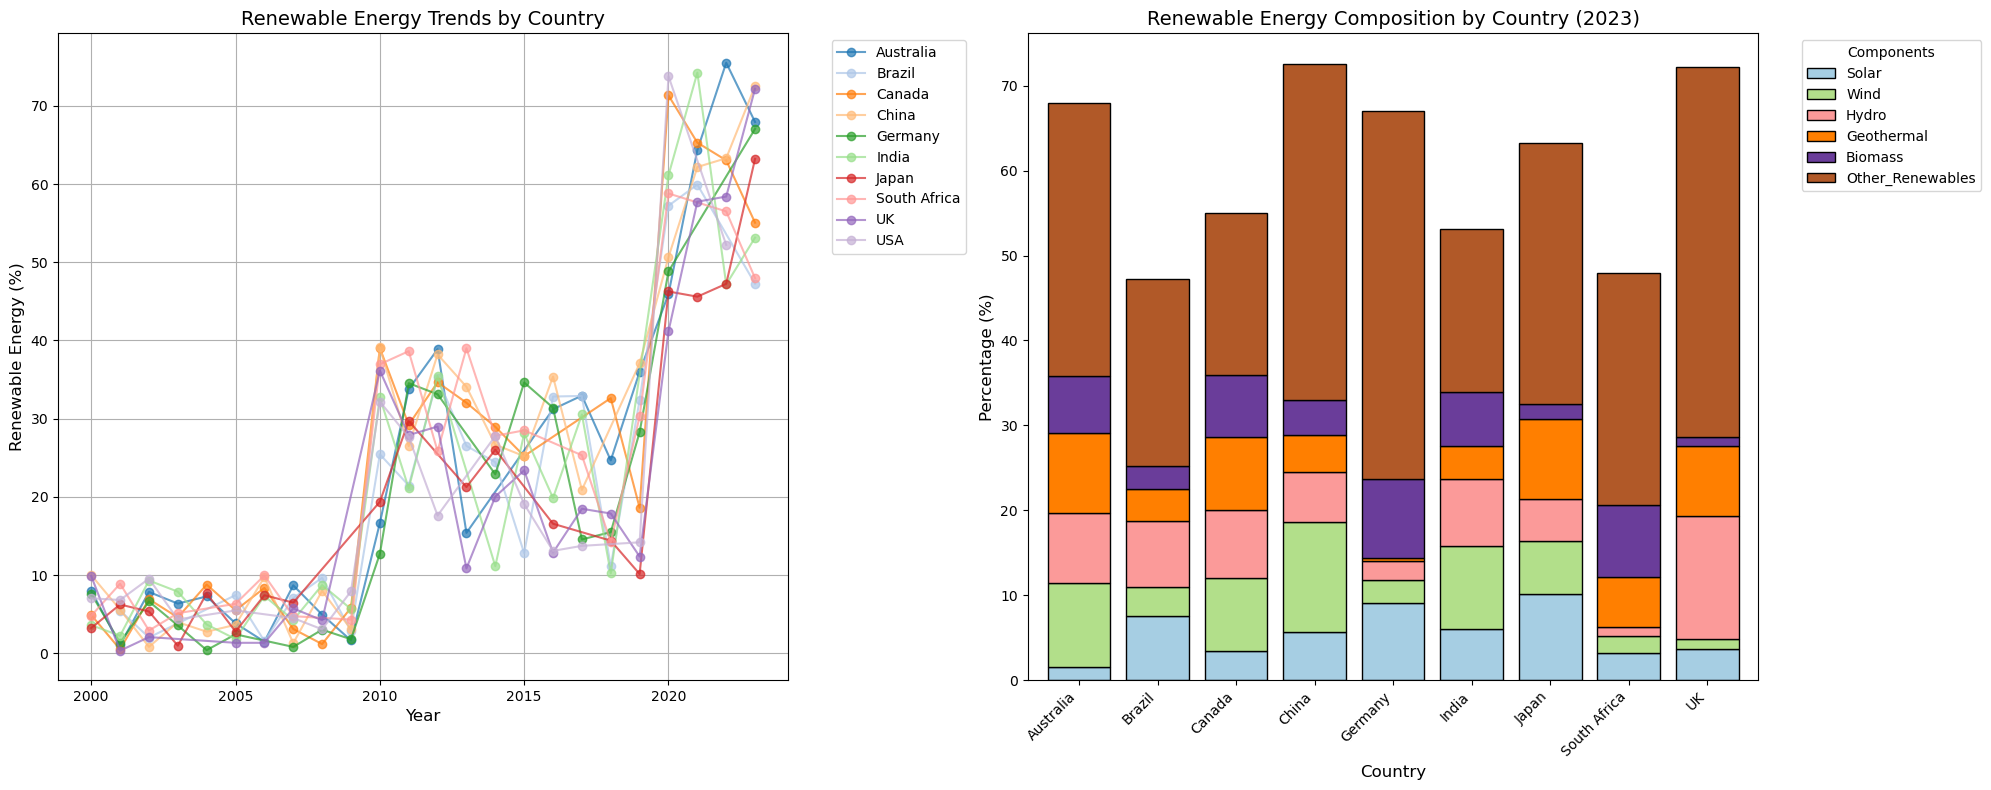

In [38]:
with Transaction() as session:		# Query data and generate visualizations
	query_data = session.query(
		SQLTable.Country,
		SQLTable.Year,
		SQLTable.Renewable_Energy,
		SQLTable.Solar,
		SQLTable.Wind,
		SQLTable.Hydro,
		SQLTable.Geothermal,
		SQLTable.Biomass,
		SQLTable.Other_Renewables
	).order_by(SQLTable.Country, SQLTable.Year).all()


data = [		# Convert query results to DataFrame for plotting
	{
		"Country": item.Country,
		"Year": item.Year,
		"Renewable_Energy": item.Renewable_Energy,
		"Solar": item.Solar,
		"Wind": item.Wind,
		"Hydro": item.Hydro,
		"Geothermal": item.Geothermal,
		"Biomass": item.Biomass,
		"Other_Renewables": item.Other_Renewables
	} for item in query_data
]
df_plot = pd.DataFrame(data)


if df_plot.empty:		# Generate plots if data exists
	print("No data found in the database.")
else:
	fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
	countries = df_plot["Country"].unique()		# Subplot 1: Renewable Energy Trends
	colors = plt.cm.tab20.colors

	for idx, country in enumerate(countries):
		country_data = df_plot[df_plot["Country"] == country]
		ax1.plot(
			country_data["Year"],
			country_data["Renewable_Energy"],
			marker="o",
			linestyle="-",
			color=colors[idx % len(colors)],
			label=country,
			alpha=0.7
		)


	ax1.set_title("Renewable Energy Trends by Country", fontsize=14)
	ax1.set_xlabel("Year", fontsize=12)
	ax1.set_ylabel("Renewable Energy (%)", fontsize=12)
	ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
	ax1.grid(True)


	latest_year = df_plot["Year"].max()			# Subplot 2: Renewable Energy Composition (Latest Year)
	latest_data = df_plot[df_plot["Year"] == latest_year]


	components = ["Solar", "Wind", "Hydro", "Geothermal", "Biomass", "Other_Renewables"]
	component_data = latest_data[["Country"] + components].set_index("Country")


	component_data.plot.bar(
		ax=ax2,
		stacked=True,
		colormap="Paired",
		edgecolor="black",
		width=0.8
	)

	ax2.set_title(f"Renewable Energy Composition by Country ({latest_year})", fontsize=14)
	ax2.set_xlabel("Country", fontsize=12)
	ax2.set_ylabel("Percentage (%)", fontsize=12)
	ax2.legend(title="Components", bbox_to_anchor=(1.05, 1), loc='upper left')
	plt.xticks(rotation=45, ha="right")


	plt.tight_layout()
	plt.show()